# Genetic Algorithms Lab

This notebook contains the work done by **Valentin Ringlet (i6191244)** and **Nick Oikonomou (i6201767)**.

- First, we'll define a generic genetic algorithm framework.

- Second, we'll implement the knapsack problem for the genetic algorithm framework.

- Third, we'll implement the travelling salesman problem (TSP) for the genetic algorithm framework.

In [1]:
# Import any needed libraries
import numpy as np
import matplotlib.pyplot as plt
import random

## Generic genetic algorithm framework

We will first implement the generic genetic algorithm framework.
To make it as customisable as possible, the generic genetic algorithm functions rely on functions provided as parameters to the functions.
The following subsections will provide first the generic genetic algorithm function that calls the generic functions for:
- selection of individuals to keep in the next generation

- crossover of individuals to generate new children

- mutation of individuals (with a certain probability)

In [2]:
def generic_genetic_algo(starting_population, number_iterations,
                         selection_population_size, select_individual_for_next_generation_fct,        # for selection function
                         select_individual_for_reproduction_fct, crossover_fct,                       # for crossover function
                         mutation_proba, apply_mutation_fct,                                          # for mutation function
                         print_stats = False
                        ):
    ''' Use the functions defined above for selection, crossover, mutation to run a genetic algorithm on the given population
    
        params:
            TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO
    '''
    # Save the size of the population
    pop_size = len(starting_population)
    
    # Then repeat creating a new population
    generation_num = 1
    previous_population = starting_population
    
    # Append the lists of fitnesses of all the individuals at each generation
    full_fitnesses = []
    
    ''' TO SEE: do we want to do a more complex monitoring of the fitness function, then stop once the fitness values of the population aren't evolving anymore '''
    while generation_num <= number_iterations:
        # First, select individuals from the previous generation to create a mating pool for this generation
        population = selection(previous_population,
                               selection_population_size,
                               select_individual_for_next_generation_fct)
        
        # Then, restore a full population by doing crossover
        population = crossover(population,
                               pop_size,
                               select_individual_for_reproduction_fct,
                               crossover_fct)
        
        # Finally, apply mutations on the population
        population = mutation(population,
                              mutation_proba,
                              apply_mutation_fct)
        
        fitnesses_i = [ind.get_fitness() for ind in population]
        
        full_fitnesses.append(fitnesses_i)
        
        if print_stats:
            print(f'\nGeneration #{generation_num}')
            print(f'Min fitness: {np.min(fitnesses_i)}')
            print(f'Average fitness: {np.mean(fitnesses_i)}')
            print(f'Max fitness: {np.max(fitnesses_i)}')
        
        # Finally, move to the next generation and save the current population as the previous generation's population
        generation_num += 1
        previous_population = population
    
    return population[fitnesses_i.index(np.max(fitnesses_i))], full_fitnesses

### Selection

In this section, we will define the function used for the selection of individuals from one generation to keep in the next generation.

In [4]:
def selection(population, num_selected_individuals, select_individual_fct):
    ''' Make a selection of individuals from the given population for the next generation.
    
        params:
            population: the previous population, from which we choose individuals
            num_selected_individuals: the number of individuals to select from the population
            select_individual_fct: the function that is used to select an individual to keep in the next generation
        
        return:
            a new population, with individuals picked from the input population,
                by using the provided function to select the individuals
    '''
    selected_list = []
    for i in range(num_selected_individuals):
        ind = select_individual_fct(population)
        while ind in selected_list:
            ind = select_individual_fct(population)
        selected_list.append(ind)
    return selected_list

### Crossover

In this section, we will define the function used for the crossover of individuals from a certain population to create children.

In [5]:
def crossover(population, final_size_population, select_parent_fct, crossover_single_fct):
    ''' Make the given population have new children by crossover.
    
        params:
            population: the individuals we start with
            final_size_population: the size we want the resulting population to be
            select_parent_fct: the function that can be used to get the individual parents
            crossover_single_fct: the function that is used to generate a child by crossover of two parents
        
        return:
            the population, with the addition of new children, to have "final_size_population" individuals in total.
                parents are selected by using the provided select_parent_fct function, and 
                the crossover is performed by using the crossover_single_fct
    '''
    start_size_population = len(population)
    
    ############################### NOT SURE IF THAT IS NECESSARY ########################################
    assert start_size_population <= final_size_population, "The population needs to be smaller than it should be after crossover"
    
    
    children = []
    for i in range(final_size_population - start_size_population):
        # Select 2 random individuals from the population
        parent1 = select_parent_fct(population)
        parent2 = select_parent_fct(population)
        # Make sure that they are different
        while (parent1 == parent2):
            parent2 = select_parent_fct(population)
        
        # Use the crossover_single function to create a new child
        child_phenotype = crossover_single_fct(parent1, parent2)
        
        child = type(parent2)(parent2.get_problem(), child_phenotype)
        
        # And add it to the population
        children.append(child)
    
    # Finally, the new population is a list with the individuals from the starting population plus the children that were generated
    return population + children

### Mutation

In this section, we will define the function used for the mutation of individuals from a given population (with a certain mutation probability).

In [6]:
def mutation(population, mutation_proba, apply_mutation_fct):
    ''' Apply mutations to some individuals from the population
    
        params:
            population: the starting population
            mutation_proba: the probability of having a mutation in a certain individual 
                It should be a real value between 0 and 1.
            apply_mutation_fct: the function used for computing the mutated phenotype based on the provided phenotype
        
        return:
            the same population, except that some individuals might have been mutated
    '''
    # For each individual
    for i in range(len(population)):
        mutate_choice = np.random.rand()
        
        # if the random number is smaller than the probability of mutation 
        if mutate_choice <= mutation_proba:
            # We apply a mutation to that individual
            #   1. get the original phenotype of the individual
            old_phenotype = population[i].get_phenotype()
            
            #   2. compute the mutated phenotype
            mutated_phenotype = apply_mutation_fct(old_phenotype, population[i].get_possible_values())
            
            #   3. replace the old individual by the new one
            population[i] = type(population[i])(population[i].get_problem(), mutated_phenotype)
    
    return population

## Specific methods for performing selection, crossover, mutation

In this section, a number of specific functions will be defined for performing the selection, crossover or mutation steps of the generic genetic algorithm framework above.

The following aspects have functions defined for them:
- Selecting an individual from a given population:

    This can be used in the **selection** step, for selecting individuals from one generation to keep in the next.
    
    But it can also be used in the **crossover** step, for selecting individuals as parents to reproduce.
    
    The following methods are available as of now:
    - select_individual_uniform_proba
    - select_individual_roulette_wheel
    
- Performing a crossover based on two individuals provided as parents:

    This is used only in the **crossover** step, to actually perform the crossover.
    
    The following methods are available as of now:
    - crossover_single_uniform_proba

- Performing a mutation, given a individual to mutate:

    This is used in the **mutation** step only, to perform the mutation.
    
    The following methods are available as of now:
    - apply_mutation_uniform_proba

In [7]:
def select_individual_uniform_proba(population):
    ''' Choose and return an individual from the given population.
        The individual is chosen using uniform probability
    
        params: 
            population: the population of individuals to chose an individual from
        
        return:
            an individual chosen from the given population
    '''
    return np.random.choice(population)

def select_individual_roulette_wheel(population):
    ''' Choose and return an individual from the given population.
        The individual is chosen using the roulette wheel selection approach
    
        params: 
            population: the population of individuals to chose an individual from
        
        return:
            an individual chosen from the given population
    '''
    #Fitness scores
    fitness_scores = [individual.get_fitness() for individual in population]
    #Total sum of fitness scores
    sum_fitness_scores =  sum([individual.get_fitness() for individual in population])
    #Create distribution
    dist = fitness_scores / sum_fitness_scores
    
    return np.random.choice(population, p = dist)


def crossover_single_uniform_crossover(parent1, parent2, crossover_proba=0.5):
    ''' Create a new child using parents individual1 and individual2.
        This version of crossover_single() uses uniform crossover.
    
        params:
            parent1: one parent of the new child
            parent2: the other parent of the new child
            crossover_proba: the probability of swapping an element of parent1 with an element of parent2 
        
        return:
            a new individual
    '''
    # Retrieve the phenotypes of the two parents
    phenotype1 = parent1.get_phenotype()
    phenotype2 = parent2.get_phenotype()
    
    # Perform the uniform crossover
    for i in range(len(phenotype1)):
        random_num = np.random.rand()
        
        # If the random number is larger than a certain probability (50 %) then we swap the values
        if random_num <= crossover_proba:
            # Swap the values at that index
            temp = phenotype1[i]
            phenotype1[i] = phenotype2[i]
            phenotype2[i] = temp
    
    # Finally, return the modified phenotype1
    return phenotype1

def apply_mutation_uniform_proba(phenotype, possible_replacement_values):
    ''' Apply a mutation on the given phenotype.
        Each index has an uniform probability of being selected, and every possible replacement value is equally likely.
        
        params:
            phenotype: the list that will be mutated
    '''
    mutation_index = np.random.randint(len(phenotype))
    
    mutation_value = np.random.choice(possible_replacement_values)
    
    phenotype[mutation_index] = mutation_value
    
    return phenotype

In [8]:
############### TALK WITH VALENTIN ABOUT THIS ################

def crossover_individual_TSP(parent1, parent2):
    '''
    Given two parents, the method creates a valid TSP child. This version chooses a part of parent 1
    to be moved. The moved nodes are also removed from parent2, then randomised and appended at the end of the parent2.
    
    params: 
        parent1: first parent
        parent2: second parent
    '''
    #Get phenotypes of parents 
    phenotype1 = parent1.get_phenotype()
    phenotype2 = parent2.get_phenotype()
    
    #Generate random number for split
    num = np.random.randint(len(phenotype1))
    
    to_be_moved = phenotype1[num:]
    
    for item in to_be_moved:
        phenotype2.remove(item)
    
    to_be_moved_randomised =  random.sample(list(to_be_moved), len(to_be_moved))
    
    child_pheno =  phenotype2 + to_be_moved_randomised
    return child_pheno


def apply_mutation_swap(phenotype, possible_replacement_values):
    ''' Apply a mutation on the given phenotype.
        This function is specifically designed for the TSP problem
        
        params:
            phenotype: the list that will be mutated
    '''
    # Select 2 indexes
    index1 = np.random.randint(len(phenotype))
    index2 = np.random.randint(len(phenotype))
    
    # Swap the 2 values
    temp = phenotype[index1]
    phenotype[index1] = phenotype[index2]
    phenotype[index2] = temp
    
    # Return the changed phenotype
    return phenotype

### Knapsack problem implementation

In [9]:
class KnapsackProblem:
    def __init__(self,n, maximum_weight):
        ''' Initialize any needed variables
        
            params:
                n: number of items for the knapsack problem 
                maximum_weight: maximum weight that the bag contains
        '''
        #Initiliase maximum allowed weight
        self.maximum_weight = maximum_weight
        #Initialise items
        self.n = n
        #Initialise weights
        self.weights = []
        for i in range(self.n):
            self.weights.append(np.random.choice(np.arange(10)+1))
        #Initialise rewards
        self.rewards = np.arange(self.n) + 1   
    
    #Return rewards
    def get_rewards(self):
        return self.rewards
    
    #Return Weights
    def get_weights(self):
        return self.weights

In [10]:
class KnapsackIndividual:
    # The possible values a single index of the phenotype can take
    list_possible_values = ['0', '1']
    
    def __init__(self, knapsackproblem, phenotype = None):            # if needed, add more parameters
        ''' Initialize any needed variables
        
            params:
                phenotype: a phenotype value that we want to set the individual to
                knapsackproblem: The knapsack problem that the individual exists
        '''
        #Initialise problem
        self.knapsackproblem = knapsackproblem
        
        if phenotype ==  None:
            #Create and initialise genotype randomly
            self.genotype = ""
            for i in range(knapsackproblem.n):
                self.genotype += str(np.random.choice(np.arange(2)))
        else:
            # Create and initialise the genotype based on the given phenotype
            self.genotype = "".join(phenotype)
        
    def get_phenotype(self):
        ''' Return the phenotype of this individual as a list type object
        '''
        return [char for char in self.genotype]
    
    def get_weight(self):
        ''' Return the total weight of this solution '''
        #Find the total weight of the individual 
        phenotype = self.get_phenotype()
        
        total_individual_weight = 0
        for i in range(len(phenotype)):
            if(phenotype[i] == "1"):
                total_individual_weight += (self.knapsackproblem.get_weights()[i])
        
        return total_individual_weight
    
    def is_legal(self):
        ''' Return the legality of the individual(weight)
        '''
        #Find the total weight of the individual 
        phenotype = self.get_phenotype()
        #Keep track of the total weight and total reward of the individual
        total_individual_weight = self.get_weight()
        
        #Check for legality
        if total_individual_weight > (self.knapsackproblem.maximum_weight):
            return False;
        else:
            return True;
    
    def get_reward(self):
        ''' Return the total reward of this individual
        '''
        #Find the total weight of the individual 
        phenotype = self.get_phenotype()
        #Total reward
        total_individual_reward = 0
        for i in range(len(phenotype)):
            if(phenotype[i] == "1"):
                total_individual_reward += (self.knapsackproblem.get_rewards()[i])
        return total_individual_reward
        
    def get_fitness(self):
        ''' Return the fitness score of this individual as a float
        '''
        if self.is_legal() == False:
            return 0;
        else:
            return self.get_reward();
    
    
    def get_possible_values(self):
        ''' Return a list of the possible values a single index of the phenotype can take.
        '''
        return self.list_possible_values
    
    def get_problem(self):
        return self.knapsackproblem

In [11]:
population = []
population_size = 100 # POPULATION SIZE CAN BE CHANGED HERE

problem = KnapsackProblem(10, 40)
for i in range(population_size):
    population.append(KnapsackIndividual(problem))


    
num_generation_runs = 1000
selection_population_size = 20
select_individual_for_next_generation_fct = select_individual_roulette_wheel
select_individual_for_reproduction_fct = select_individual_uniform_proba
crossover_fct = crossover_single_uniform_crossover
mutation_proba = 0.05
apply_mutation_fct = apply_mutation_swap

print_fitnesses = True
best_individual, stats_Knapsack = generic_genetic_algo(population, num_generation_runs,
                                              selection_population_size, select_individual_for_next_generation_fct,        # for selection function
                                              select_individual_for_reproduction_fct, crossover_fct,                       # for crossover function
                                              mutation_proba, apply_mutation_fct,                                          # for mutation function
                                              print_fitnesses
                                              )


print(f'\nTop performing individual: \nFitness score: {best_individual.get_fitness()}\nWeight: {best_individual.get_phenotype()}')

print(f'Problem: \nWeights are {problem.get_weights()}\nRewards are {problem.get_rewards()}')



# Make some plots with the list of fitnesses of all individuals over all generations ?
# --> could use "stats" for that


Generation #1
Min fitness: 0
Average fitness: 26.72
Max fitness: 43

Generation #2
Min fitness: 0
Average fitness: 29.07
Max fitness: 47

Generation #3
Min fitness: 0
Average fitness: 31.81
Max fitness: 51

Generation #4
Min fitness: 0
Average fitness: 35.5
Max fitness: 51

Generation #5
Min fitness: 0
Average fitness: 37.05
Max fitness: 51

Generation #6
Min fitness: 0
Average fitness: 36.25
Max fitness: 51

Generation #7
Min fitness: 0
Average fitness: 36.82
Max fitness: 47

Generation #8
Min fitness: 23
Average fitness: 39.02
Max fitness: 47

Generation #9
Min fitness: 0
Average fitness: 38.14
Max fitness: 48

Generation #10
Min fitness: 0
Average fitness: 39.19
Max fitness: 47

Generation #11
Min fitness: 32
Average fitness: 39.83
Max fitness: 47

Generation #12
Min fitness: 27
Average fitness: 39.84
Max fitness: 47

Generation #13
Min fitness: 26
Average fitness: 39.75
Max fitness: 47

Generation #14
Min fitness: 27
Average fitness: 39.23
Max fitness: 47

Generation #15
Min fitne


Generation #119
Min fitness: 39
Average fitness: 44.98
Max fitness: 49

Generation #120
Min fitness: 39
Average fitness: 45.1
Max fitness: 50

Generation #121
Min fitness: 42
Average fitness: 44.96
Max fitness: 46

Generation #122
Min fitness: 45
Average fitness: 45.0
Max fitness: 45

Generation #123
Min fitness: 45
Average fitness: 45.0
Max fitness: 45

Generation #124
Min fitness: 43
Average fitness: 44.97
Max fitness: 45

Generation #125
Min fitness: 38
Average fitness: 44.79
Max fitness: 46

Generation #126
Min fitness: 0
Average fitness: 43.55
Max fitness: 50

Generation #127
Min fitness: 0
Average fitness: 41.98
Max fitness: 50

Generation #128
Min fitness: 0
Average fitness: 44.12
Max fitness: 46

Generation #129
Min fitness: 37
Average fitness: 44.26
Max fitness: 45

Generation #130
Min fitness: 40
Average fitness: 44.91
Max fitness: 45

Generation #131
Min fitness: 0
Average fitness: 43.4
Max fitness: 46

Generation #132
Min fitness: 0
Average fitness: 43.36
Max fitness: 47




Generation #234
Min fitness: 0
Average fitness: 49.21
Max fitness: 50

Generation #235
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #236
Min fitness: 0
Average fitness: 49.43
Max fitness: 50

Generation #237
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #238
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #239
Min fitness: 0
Average fitness: 49.0
Max fitness: 50

Generation #240
Min fitness: 0
Average fitness: 48.92
Max fitness: 50

Generation #241
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #242
Min fitness: 42
Average fitness: 49.92
Max fitness: 50

Generation #243
Min fitness: 45
Average fitness: 49.93
Max fitness: 50

Generation #244
Min fitness: 42
Average fitness: 49.74
Max fitness: 50

Generation #245
Min fitness: 0
Average fitness: 49.48
Max fitness: 50

Generation #246
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #247
Min fitness: 48
Average fitness: 49.98
Max fitness: 50

Gen


Generation #351
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #352
Min fitness: 0
Average fitness: 49.51
Max fitness: 51

Generation #353
Min fitness: 47
Average fitness: 49.95
Max fitness: 50

Generation #354
Min fitness: 45
Average fitness: 49.91
Max fitness: 50

Generation #355
Min fitness: 0
Average fitness: 48.69
Max fitness: 50

Generation #356
Min fitness: 0
Average fitness: 47.91
Max fitness: 50

Generation #357
Min fitness: 0
Average fitness: 47.81
Max fitness: 50

Generation #358
Min fitness: 0
Average fitness: 49.02
Max fitness: 50

Generation #359
Min fitness: 0
Average fitness: 49.0
Max fitness: 50

Generation #360
Min fitness: 0
Average fitness: 49.43
Max fitness: 50

Generation #361
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #362
Min fitness: 0
Average fitness: 49.0
Max fitness: 50

Generation #363
Min fitness: 0
Average fitness: 49.44
Max fitness: 50

Generation #364
Min fitness: 44
Average fitness: 49.85
Max fitness: 50

Genera


Generation #468
Min fitness: 42
Average fitness: 49.86
Max fitness: 50

Generation #469
Min fitness: 0
Average fitness: 49.13
Max fitness: 51

Generation #470
Min fitness: 0
Average fitness: 49.45
Max fitness: 50

Generation #471
Min fitness: 0
Average fitness: 49.15
Max fitness: 50

Generation #472
Min fitness: 0
Average fitness: 48.61
Max fitness: 51

Generation #473
Min fitness: 0
Average fitness: 47.54
Max fitness: 50

Generation #474
Min fitness: 0
Average fitness: 48.51
Max fitness: 51

Generation #475
Min fitness: 0
Average fitness: 48.46
Max fitness: 51

Generation #476
Min fitness: 46
Average fitness: 49.54
Max fitness: 51

Generation #477
Min fitness: 0
Average fitness: 48.47
Max fitness: 50

Generation #478
Min fitness: 44
Average fitness: 48.65
Max fitness: 51

Generation #479
Min fitness: 0
Average fitness: 46.3
Max fitness: 51

Generation #480
Min fitness: 0
Average fitness: 47.53
Max fitness: 50

Generation #481
Min fitness: 0
Average fitness: 47.2
Max fitness: 50

Gene


Generation #586
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #587
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #588
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #589
Min fitness: 0
Average fitness: 49.4
Max fitness: 50

Generation #590
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #591
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #592
Min fitness: 48
Average fitness: 49.97
Max fitness: 50

Generation #593
Min fitness: 0
Average fitness: 48.41
Max fitness: 50

Generation #594
Min fitness: 0
Average fitness: 48.3
Max fitness: 50

Generation #595
Min fitness: 0
Average fitness: 48.61
Max fitness: 50

Generation #596
Min fitness: 0
Average fitness: 47.56
Max fitness: 50

Generation #597
Min fitness: 46
Average fitness: 49.65
Max fitness: 50

Generation #598
Min fitness: 0
Average fitness: 46.81
Max fitness: 50

Generation #599
Min fitness: 0
Average fitness: 48.84
Max fitness: 50

Genera


Generation #703
Min fitness: 0
Average fitness: 47.59
Max fitness: 50

Generation #704
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #705
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #706
Min fitness: 0
Average fitness: 49.49
Max fitness: 50

Generation #707
Min fitness: 46
Average fitness: 49.93
Max fitness: 50

Generation #708
Min fitness: 0
Average fitness: 46.25
Max fitness: 50

Generation #709
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #710
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #711
Min fitness: 0
Average fitness: 49.43
Max fitness: 50

Generation #712
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #713
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #714
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #715
Min fitness: 0
Average fitness: 49.48
Max fitness: 50

Generation #716
Min fitness: 0
Average fitness: 48.97
Max fitness: 50

Generati


Generation #819
Min fitness: 46
Average fitness: 49.96
Max fitness: 50

Generation #820
Min fitness: 0
Average fitness: 49.43
Max fitness: 50

Generation #821
Min fitness: 0
Average fitness: 45.92
Max fitness: 50

Generation #822
Min fitness: 0
Average fitness: 46.48
Max fitness: 50

Generation #823
Min fitness: 0
Average fitness: 47.97
Max fitness: 50

Generation #824
Min fitness: 0
Average fitness: 47.92
Max fitness: 50

Generation #825
Min fitness: 43
Average fitness: 49.08
Max fitness: 50

Generation #826
Min fitness: 39
Average fitness: 48.42
Max fitness: 50

Generation #827
Min fitness: 0
Average fitness: 48.72
Max fitness: 50

Generation #828
Min fitness: 0
Average fitness: 47.75
Max fitness: 50

Generation #829
Min fitness: 43
Average fitness: 48.22
Max fitness: 50

Generation #830
Min fitness: 0
Average fitness: 47.66
Max fitness: 50

Generation #831
Min fitness: 0
Average fitness: 47.98
Max fitness: 50

Generation #832
Min fitness: 0
Average fitness: 46.99
Max fitness: 50

G


Generation #936
Min fitness: 0
Average fitness: 49.47
Max fitness: 50

Generation #937
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #938
Min fitness: 45
Average fitness: 49.95
Max fitness: 50

Generation #939
Min fitness: 0
Average fitness: 48.27
Max fitness: 50

Generation #940
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #941
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #942
Min fitness: 47
Average fitness: 49.97
Max fitness: 50

Generation #943
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #944
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #945
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #946
Min fitness: 0
Average fitness: 48.49
Max fitness: 50

Generation #947
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #948
Min fitness: 0
Average fitness: 49.46
Max fitness: 50

Generation #949
Min fitness: 45
Average fitness: 49.96
Max fitness: 51

Gener

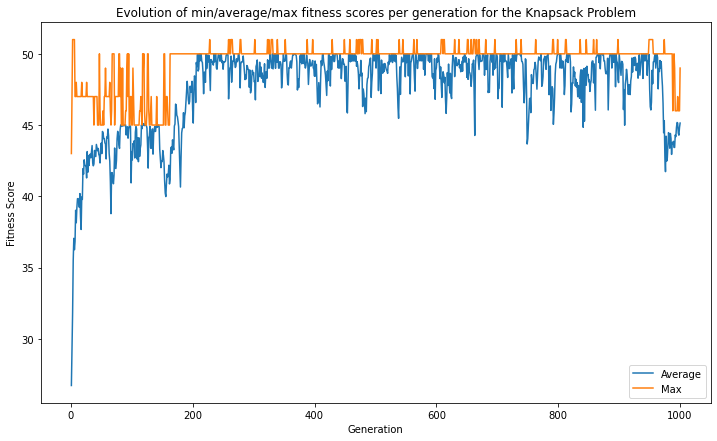

In [16]:
# Plotting Fitness Data
#############  TSP ############
min_fit_KN = [np.min(item) for item in stats_Knapsack]
max_fit_KN = [np.max(item) for item in stats_Knapsack]
avg_fit_KN = [np.mean(item) for item in stats_Knapsack]


# Plot the computed data
plt.figure(figsize = (12,7))
#plt.plot(np.arange(num_generation_runs) +1 , min_fit_KN)
plt.plot(np.arange(num_generation_runs) +1 , avg_fit_KN)
plt.plot(np.arange(num_generation_runs) +1 , max_fit_KN)
plt.ylabel("Fitness Score")
plt.xlabel("Generation")
plt.title("Evolution of min/average/max fitness scores per generation for the Knapsack Problem")
plt.legend([ "Average", "Max"])
plt.show()

### Travelling salesman problem

In [17]:
class TSPProblem:
    def __init__(self, number_of_cities):
        '''Initiliaze the variables for the problem
        
            params:
                number_of_cities: define the number of cities in the problem
        '''
        #Initialise number of cities in the graph 
        self.number_of_cities = number_of_cities
        
        #Initialise nodes 
        self.nodes = np.arange(number_of_cities)
        
        #Define the representation
        self.representation = - np.ones((self.number_of_cities, self.number_of_cities));
        for i in range(number_of_cities):
            for j in range(number_of_cities):
                if i == j:
                    self.representation[i][j] = 0
                elif self.representation[j][i] != -1:
                    # Copy the value to have a symmetric matrix (as distance(0, 1) should be the same as distance(1, 0))
                    self.representation[i][j] = self.representation[j][i]
                else:
                    distance = np.random.choice(np.arange(10) + 1)
                    self.representation[i][j] = distance
        
    def get_representation(self):
        return self.representation
    
    def get_nodes(self):
        return self.nodes
    
    def get_distance(self,node1,node2):
        return self.representation[node1][node2]

In [18]:
class TSPIndividual:
    
    def __init__(self, tspproblem, phenotype=None):  # if needed, add more parameters
        ''' Initialize any needed variables
        
            params:
                tspproblem: a phenotype value that we want to set the individual to
        '''
        #Initialise the problem that we are working on
        self.tspproblem = tspproblem
        
        #List of possible values
        self.list_possible_values = self.tspproblem.get_nodes()
        
        
        # Initialise the genotype which is made up of a list of all cities except they have to start and end with the city 0
        if phenotype ==  None:
            #Create and initialise genotype randomly
            two_onwards = np.arange(1,tspproblem.number_of_cities)
            geno_temp = random.sample(list(two_onwards), len(two_onwards))
            geno_temp.append(0)
            geno_temp.insert(0, 0)
            self.genotype = geno_temp
        else:
            # Create and initialise the genotype based on the given phenotype
            self.genotype = phenotype
            self.genotype.append(0)
            self.genotype.insert(0, 0)
    
    def get_weight(self):
        total_weight = 0
        rep = self.tspproblem.get_representation()
        pheno = self.get_genotype()
        for i in range(0,len(pheno)-1):
            total_weight += rep[pheno[i]][pheno[i+1]]
        return total_weight
    
    def get_phenotype(self):
        ''' Return the genotype without the start and end city (which should both be 0) as a list type object
        '''
        l = self.genotype[1:len(self.genotype)-1]
        return l
        
    def get_genotype(self):
        ''' Return the genotype of this individual as a list type object
        '''
        return self.genotype
    
    def get_fitness(self):
        ''' Return the fitness score of this individual as a float
        '''
        maximum = np.sum(self.tspproblem.get_representation())//2
        
        return maximum - self.get_weight()
    
    def get_possible_values(self):
        ''' Return a list of the possible values a single index of the phenotype can take.
        '''
        return self.list_possible_values
        
    def get_problem(self):
        return self.tspproblem

In [19]:
population = []
population_size = 100 # POPULATION SIZE CAN BE CHANGED HERE

problem = TSPProblem(10)
for i in range(population_size):
    population.append(TSPIndividual(problem))



num_generation_runs = 1000
selection_population_size = 20
select_individual_for_next_generation_fct = select_individual_roulette_wheel
select_individual_for_reproduction_fct = select_individual_uniform_proba
crossover_fct = crossover_individual_TSP
mutation_proba = 0.05
apply_mutation_fct = apply_mutation_swap

print_fitnesses = True
best_individual, stats = generic_genetic_algo(population, num_generation_runs,
                                        selection_population_size, select_individual_for_next_generation_fct,        # for selection function
                                        select_individual_for_reproduction_fct, crossover_fct,                       # for crossover function
                                        mutation_proba, apply_mutation_fct,                                          # for mutation function
                                        print_fitnesses
                                        )


print(f'\nTop performing individual: \nFitness score: {best_individual.get_fitness()}\nGenotype: {best_individual.get_genotype()}')

print(f'Problem: \nDistances between cities are \n{problem.get_representation()}')



# Make some plots with the list of fitnesses of all individuals over all generations ?
# --> could use "stats" for that


Generation #1
Min fitness: 174.0
Average fitness: 195.95
Max fitness: 210.0

Generation #2
Min fitness: 180.0
Average fitness: 195.4
Max fitness: 212.0

Generation #3
Min fitness: 184.0
Average fitness: 196.93
Max fitness: 211.0

Generation #4
Min fitness: 174.0
Average fitness: 196.52
Max fitness: 217.0

Generation #5
Min fitness: 180.0
Average fitness: 197.02
Max fitness: 219.0

Generation #6
Min fitness: 173.0
Average fitness: 198.28
Max fitness: 219.0

Generation #7
Min fitness: 180.0
Average fitness: 198.55
Max fitness: 217.0

Generation #8
Min fitness: 176.0
Average fitness: 199.73
Max fitness: 221.0

Generation #9
Min fitness: 178.0
Average fitness: 198.12
Max fitness: 216.0

Generation #10
Min fitness: 176.0
Average fitness: 198.51
Max fitness: 218.0

Generation #11
Min fitness: 176.0
Average fitness: 198.82
Max fitness: 218.0

Generation #12
Min fitness: 177.0
Average fitness: 197.4
Max fitness: 211.0

Generation #13
Min fitness: 179.0
Average fitness: 199.42
Max fitness: 219


Generation #107
Min fitness: 179.0
Average fitness: 195.69
Max fitness: 218.0

Generation #108
Min fitness: 177.0
Average fitness: 196.11
Max fitness: 216.0

Generation #109
Min fitness: 177.0
Average fitness: 196.41
Max fitness: 216.0

Generation #110
Min fitness: 178.0
Average fitness: 195.19
Max fitness: 215.0

Generation #111
Min fitness: 173.0
Average fitness: 196.64
Max fitness: 213.0

Generation #112
Min fitness: 180.0
Average fitness: 198.7
Max fitness: 213.0

Generation #113
Min fitness: 180.0
Average fitness: 199.28
Max fitness: 215.0

Generation #114
Min fitness: 180.0
Average fitness: 200.88
Max fitness: 226.0

Generation #115
Min fitness: 180.0
Average fitness: 198.12
Max fitness: 219.0

Generation #116
Min fitness: 176.0
Average fitness: 197.69
Max fitness: 220.0

Generation #117
Min fitness: 176.0
Average fitness: 198.33
Max fitness: 217.0

Generation #118
Min fitness: 169.0
Average fitness: 199.06
Max fitness: 218.0

Generation #119
Min fitness: 183.0
Average fitness: 


Generation #212
Min fitness: 180.0
Average fitness: 198.25
Max fitness: 215.0

Generation #213
Min fitness: 179.0
Average fitness: 197.71
Max fitness: 219.0

Generation #214
Min fitness: 179.0
Average fitness: 196.4
Max fitness: 213.0

Generation #215
Min fitness: 180.0
Average fitness: 196.63
Max fitness: 214.0

Generation #216
Min fitness: 181.0
Average fitness: 199.04
Max fitness: 223.0

Generation #217
Min fitness: 181.0
Average fitness: 200.63
Max fitness: 223.0

Generation #218
Min fitness: 181.0
Average fitness: 199.72
Max fitness: 218.0

Generation #219
Min fitness: 184.0
Average fitness: 199.73
Max fitness: 216.0

Generation #220
Min fitness: 183.0
Average fitness: 199.82
Max fitness: 218.0

Generation #221
Min fitness: 176.0
Average fitness: 197.51
Max fitness: 218.0

Generation #222
Min fitness: 178.0
Average fitness: 198.68
Max fitness: 212.0

Generation #223
Min fitness: 181.0
Average fitness: 198.51
Max fitness: 216.0

Generation #224
Min fitness: 180.0
Average fitness: 


Generation #317
Min fitness: 183.0
Average fitness: 198.03
Max fitness: 217.0

Generation #318
Min fitness: 179.0
Average fitness: 198.06
Max fitness: 215.0

Generation #319
Min fitness: 176.0
Average fitness: 196.32
Max fitness: 216.0

Generation #320
Min fitness: 179.0
Average fitness: 197.68
Max fitness: 214.0

Generation #321
Min fitness: 182.0
Average fitness: 195.86
Max fitness: 216.0

Generation #322
Min fitness: 177.0
Average fitness: 194.95
Max fitness: 216.0

Generation #323
Min fitness: 174.0
Average fitness: 196.33
Max fitness: 217.0

Generation #324
Min fitness: 176.0
Average fitness: 198.71
Max fitness: 217.0

Generation #325
Min fitness: 182.0
Average fitness: 196.75
Max fitness: 217.0

Generation #326
Min fitness: 180.0
Average fitness: 198.2
Max fitness: 217.0

Generation #327
Min fitness: 175.0
Average fitness: 195.71
Max fitness: 216.0

Generation #328
Min fitness: 177.0
Average fitness: 197.41
Max fitness: 216.0

Generation #329
Min fitness: 183.0
Average fitness: 


Generation #422
Min fitness: 180.0
Average fitness: 198.4
Max fitness: 222.0

Generation #423
Min fitness: 172.0
Average fitness: 197.02
Max fitness: 222.0

Generation #424
Min fitness: 172.0
Average fitness: 198.67
Max fitness: 222.0

Generation #425
Min fitness: 172.0
Average fitness: 198.37
Max fitness: 222.0

Generation #426
Min fitness: 175.0
Average fitness: 197.21
Max fitness: 219.0

Generation #427
Min fitness: 174.0
Average fitness: 196.49
Max fitness: 219.0

Generation #428
Min fitness: 179.0
Average fitness: 198.88
Max fitness: 218.0

Generation #429
Min fitness: 180.0
Average fitness: 198.81
Max fitness: 213.0

Generation #430
Min fitness: 179.0
Average fitness: 198.15
Max fitness: 215.0

Generation #431
Min fitness: 183.0
Average fitness: 195.7
Max fitness: 215.0

Generation #432
Min fitness: 183.0
Average fitness: 195.66
Max fitness: 212.0

Generation #433
Min fitness: 181.0
Average fitness: 197.76
Max fitness: 216.0

Generation #434
Min fitness: 181.0
Average fitness: 1


Generation #527
Min fitness: 178.0
Average fitness: 197.59
Max fitness: 215.0

Generation #528
Min fitness: 174.0
Average fitness: 196.32
Max fitness: 220.0

Generation #529
Min fitness: 174.0
Average fitness: 193.86
Max fitness: 211.0

Generation #530
Min fitness: 175.0
Average fitness: 196.38
Max fitness: 222.0

Generation #531
Min fitness: 175.0
Average fitness: 195.22
Max fitness: 216.0

Generation #532
Min fitness: 176.0
Average fitness: 195.56
Max fitness: 213.0

Generation #533
Min fitness: 179.0
Average fitness: 196.54
Max fitness: 212.0

Generation #534
Min fitness: 178.0
Average fitness: 197.39
Max fitness: 219.0

Generation #535
Min fitness: 182.0
Average fitness: 198.0
Max fitness: 216.0

Generation #536
Min fitness: 179.0
Average fitness: 198.32
Max fitness: 220.0

Generation #537
Min fitness: 181.0
Average fitness: 199.0
Max fitness: 219.0

Generation #538
Min fitness: 179.0
Average fitness: 197.14
Max fitness: 212.0

Generation #539
Min fitness: 176.0
Average fitness: 1


Generation #631
Min fitness: 180.0
Average fitness: 195.9
Max fitness: 215.0

Generation #632
Min fitness: 176.0
Average fitness: 196.19
Max fitness: 218.0

Generation #633
Min fitness: 181.0
Average fitness: 197.31
Max fitness: 216.0

Generation #634
Min fitness: 176.0
Average fitness: 195.76
Max fitness: 216.0

Generation #635
Min fitness: 173.0
Average fitness: 196.87
Max fitness: 216.0

Generation #636
Min fitness: 175.0
Average fitness: 195.03
Max fitness: 216.0

Generation #637
Min fitness: 179.0
Average fitness: 196.08
Max fitness: 217.0

Generation #638
Min fitness: 179.0
Average fitness: 196.25
Max fitness: 218.0

Generation #639
Min fitness: 176.0
Average fitness: 196.61
Max fitness: 217.0

Generation #640
Min fitness: 180.0
Average fitness: 195.94
Max fitness: 218.0

Generation #641
Min fitness: 178.0
Average fitness: 195.56
Max fitness: 216.0

Generation #642
Min fitness: 178.0
Average fitness: 195.25
Max fitness: 216.0

Generation #643
Min fitness: 174.0
Average fitness: 

Generation #735
Min fitness: 176.0
Average fitness: 197.55
Max fitness: 220.0

Generation #736
Min fitness: 175.0
Average fitness: 197.74
Max fitness: 217.0

Generation #737
Min fitness: 170.0
Average fitness: 196.29
Max fitness: 215.0

Generation #738
Min fitness: 174.0
Average fitness: 195.89
Max fitness: 218.0

Generation #739
Min fitness: 177.0
Average fitness: 195.39
Max fitness: 211.0

Generation #740
Min fitness: 179.0
Average fitness: 195.88
Max fitness: 213.0

Generation #741
Min fitness: 180.0
Average fitness: 195.57
Max fitness: 213.0

Generation #742
Min fitness: 181.0
Average fitness: 196.71
Max fitness: 216.0

Generation #743
Min fitness: 180.0
Average fitness: 197.68
Max fitness: 216.0

Generation #744
Min fitness: 180.0
Average fitness: 197.02
Max fitness: 215.0

Generation #745
Min fitness: 177.0
Average fitness: 197.66
Max fitness: 212.0

Generation #746
Min fitness: 175.0
Average fitness: 196.72
Max fitness: 220.0

Generation #747
Min fitness: 179.0
Average fitness: 


Generation #840
Min fitness: 178.0
Average fitness: 195.55
Max fitness: 215.0

Generation #841
Min fitness: 169.0
Average fitness: 195.86
Max fitness: 211.0

Generation #842
Min fitness: 180.0
Average fitness: 196.66
Max fitness: 214.0

Generation #843
Min fitness: 177.0
Average fitness: 195.93
Max fitness: 219.0

Generation #844
Min fitness: 180.0
Average fitness: 198.11
Max fitness: 219.0

Generation #845
Min fitness: 179.0
Average fitness: 197.91
Max fitness: 219.0

Generation #846
Min fitness: 181.0
Average fitness: 198.02
Max fitness: 219.0

Generation #847
Min fitness: 179.0
Average fitness: 198.02
Max fitness: 221.0

Generation #848
Min fitness: 179.0
Average fitness: 198.04
Max fitness: 219.0

Generation #849
Min fitness: 181.0
Average fitness: 197.35
Max fitness: 212.0

Generation #850
Min fitness: 175.0
Average fitness: 196.25
Max fitness: 216.0

Generation #851
Min fitness: 175.0
Average fitness: 195.01
Max fitness: 214.0

Generation #852
Min fitness: 180.0
Average fitness:


Generation #944
Min fitness: 180.0
Average fitness: 196.39
Max fitness: 212.0

Generation #945
Min fitness: 177.0
Average fitness: 196.42
Max fitness: 215.0

Generation #946
Min fitness: 177.0
Average fitness: 196.56
Max fitness: 220.0

Generation #947
Min fitness: 180.0
Average fitness: 195.68
Max fitness: 218.0

Generation #948
Min fitness: 177.0
Average fitness: 194.87
Max fitness: 217.0

Generation #949
Min fitness: 177.0
Average fitness: 197.45
Max fitness: 218.0

Generation #950
Min fitness: 181.0
Average fitness: 195.73
Max fitness: 217.0

Generation #951
Min fitness: 181.0
Average fitness: 195.59
Max fitness: 211.0

Generation #952
Min fitness: 174.0
Average fitness: 194.02
Max fitness: 210.0

Generation #953
Min fitness: 178.0
Average fitness: 195.37
Max fitness: 216.0

Generation #954
Min fitness: 178.0
Average fitness: 195.85
Max fitness: 211.0

Generation #955
Min fitness: 179.0
Average fitness: 196.12
Max fitness: 217.0

Generation #956
Min fitness: 178.0
Average fitness:

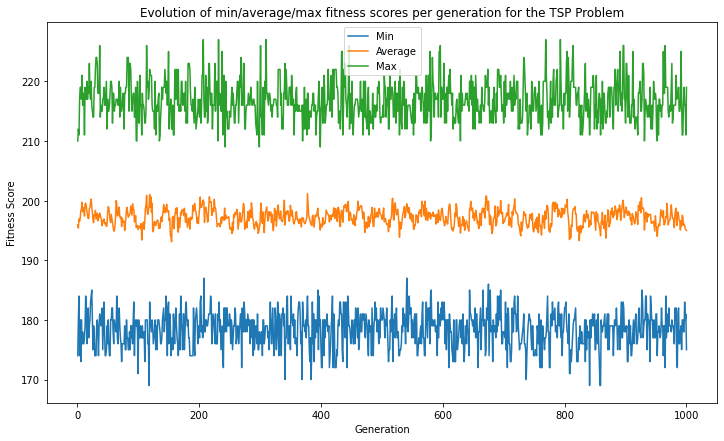

In [20]:
# Plotting Fitness Data
#############  TSP ############
min_fit_TSP = [np.min(item) for item in stats]
max_fit_TSP = [np.max(item) for item in stats]
avg_fit_TSP = [np.mean(item) for item in stats]

# Plot the data
plt.figure(figsize = (12,7))
plt.plot(np.arange(num_generation_runs) +1 , min_fit_TSP)
plt.plot(np.arange(num_generation_runs) +1 , avg_fit_TSP)
plt.plot(np.arange(num_generation_runs) +1 , max_fit_TSP)
plt.ylabel("Fitness Score")
plt.xlabel("Generation")
plt.title("Evolution of min/average/max fitness scores per generation for the TSP Problem")
plt.legend(["Min", "Average", "Max"])
plt.show()